In [170]:
%matplotlib inline

import pandas
import numpy
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics, model_selection, preprocessing, pipeline

# ML methods
from sklearn.ensemble import RandomForestClassifier

## Tools

In [171]:
# From http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=numpy.linspace(.1, 1.0, 5)):
    np = numpy
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    s = model_selection.learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_sizes, train_scores, test_scores = s
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Data

In [172]:
test_csv = pandas.read_csv('./test.csv')
train_csv = pandas.read_csv('./train.csv')
raw = pandas.concat([test_csv, train_csv])
raw[:2]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,NaN,330911
1,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,NaN,363272


In [173]:
raw['Embarked'].unique()

array(['Q', 'S', 'C', nan], dtype=object)

In [174]:
raw['Parch'].unique()

array([0, 1, 3, 2, 4, 6, 5, 9])

In [175]:
raw['SibSp'].unique()

array([0, 1, 2, 3, 4, 5, 8])

In [176]:
raw.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [191]:
data = pandas.DataFrame({
    'sex': raw['Sex'].astype('category'),
    'age': raw['Age'],
    'fare': raw['Fare'],
    'survived': raw['Survived'],
    'sibsp': raw['SibSp'],
    'parch': raw['Parch'],
    'embarked': raw['Embarked'],
})
data.index=raw['PassengerId']
data = pandas.get_dummies(data, columns=None, drop_first=True)
data[:2]

,age,fare,parch,sibsp,survived,embarked_Q,embarked_S,sex_male
PassengerId,,,,,,,,
892,34.5,7.8292,0,0,NaN,1,0,1
893,47.0,7.0000,0,1,NaN,0,1,0


In [192]:
without_result = data['survived'].isnull()
has_result = ~without_result
target_columns = ['survived']
data_columns = list(set(data.columns) - set(target_columns))

test_size = 0.3
seed = 1
s = model_selection.train_test_split(data[has_result][data_columns], data[has_result][target_columns], test_size=test_size, random_state=seed)
X_train, X_test, Y_train, Y_test = s
Y_train = Y_train['survived']
Y_test = Y_test['survived']

# Model

Fitting 7 folds for each of 42 candidates, totalling 294 fits


[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:  2.5min finished


Using parameters {'randomforestclassifier__min_samples_split': 0.02, 'randomforestclassifier__n_estimators': 80}
Test set accuracy: 75.75%


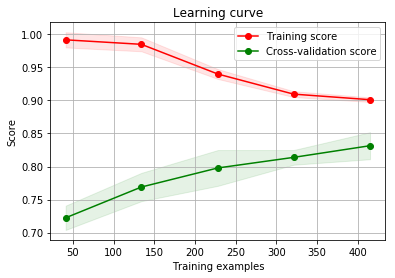

In [197]:
estimator = pipeline.make_pipeline(
    preprocessing.Imputer(strategy='mean'),
    RandomForestClassifier(),
)
parameters = {
    'randomforestclassifier__n_estimators': [ 20, 40, 60, 80, 100, 120, 140 ],
    'randomforestclassifier__min_samples_split': [ 0.05, 0.03, 0.025, 0.02, 0.01, 0.005, ],
}
search = model_selection.GridSearchCV(estimator, parameters, cv=7, verbose=1)
search.fit(X_train, Y_train)

# Evaluation
print('Using parameters', search.best_params_)

plot_learning_curve(search.best_estimator_, 'Learning curve', X_train, Y_train)

Y_pred = search.best_estimator_.predict(X_test)
print('Test set accuracy: %.2f%%' % (metrics.accuracy_score(Y_pred, Y_test)*100,))

In [194]:
def make_submission(estimator):
    without_result = data['survived'].isnull()
    d = data[without_result][data_columns]
    
    s = pandas.DataFrame({
        'PassengerId': d.index,
        'Survived': estimator.predict(d).astype('int'),
    })
    s.to_csv('submission.csv', index=False)
    return s
    
make_submission(search.best_estimator_);